In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import nltk
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

import string


In [2]:
#Por ahora uso el titulo pero hay que probar y comparar con el body

In [3]:
dataset = pd.read_json('dataset_amazon/dataset_es_train.json', lines = True)
dataset

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes
...,...,...,...,...,...,...,...,...
199995,es_0715276,product_es_0317036,reviewer_es_0643604,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,es,electronics
199996,es_0085190,product_es_0622919,reviewer_es_0466173,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,es,electronics
199997,es_0484496,product_es_0358101,reviewer_es_0330744,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,es,apparel
199998,es_0930141,product_es_0788855,reviewer_es_0694290,5,Perfecto para el cumple de mi hijo,Recomendado,es,toy


In [4]:
print(dataset.isnull().sum())

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64


In [5]:
dataset.drop(['language','reviewer_id'],axis = 1,inplace=True)
dataset

,review_id,product_id,stars,review_body,review_title,product_category
0,es_0491108,product_es_0296024,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electronics
1,es_0869872,product_es_0922286,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electronics
2,es_0811721,product_es_0474543,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,drugstore
3,es_0359921,product_es_0656090,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,wireless
4,es_0068940,product_es_0662544,1,Llega tarde y co la talla equivocada,Devuelto,shoes
...,...,...,...,...,...,...
199995,es_0715276,product_es_0317036,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,electronics
199996,es_0085190,product_es_0622919,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,electronics
199997,es_0484496,product_es_0358101,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,apparel
199998,es_0930141,product_es_0788855,5,Perfecto para el cumple de mi hijo,Recomendado,toy


<b>¿Que categorias tienen más reviews?</b>

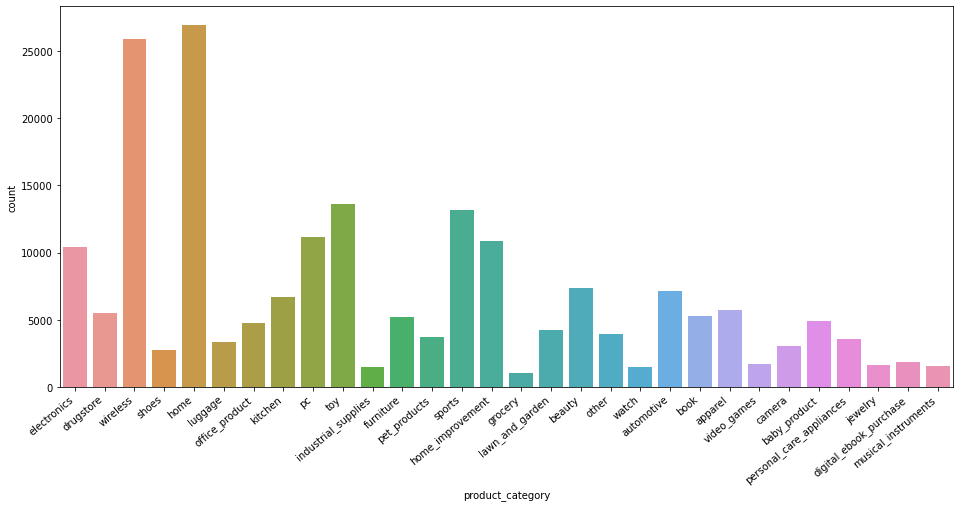

In [6]:
plt.figure(figsize=(16,7))
ax = sns.countplot(x="product_category", data=dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")#Inclino las etiquetas
plt.show()

<b>¿Hay alguna categoría que presente una mayor cantiadad de satisfacción o instatisfacción en los productos?<b>

Buscamos si el dataset tiene alguna categoría que presente una mayor cantiadad de satisfacción o instatisfacción en los productos.
<br>
Graficamos la cantidad de estrellas de cada categoria

<AxesSubplot:xlabel='product_category'>

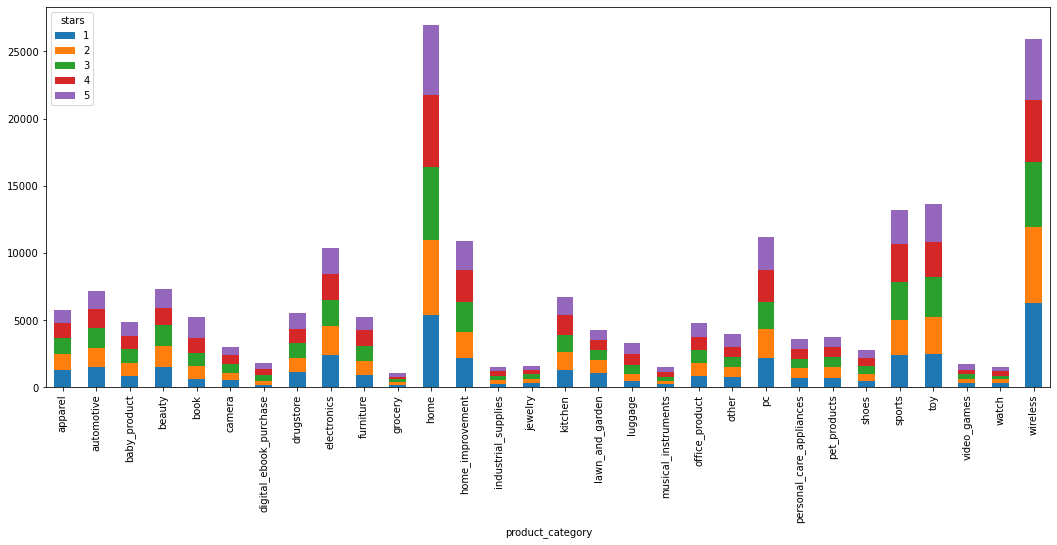

In [7]:
dataset.groupby(['product_category','stars'])['stars'].count().unstack().plot(kind='bar', stacked=True, figsize=(18,7))

In [8]:
nlp = spacy.load("es_core_news_sm")


## Normalización

Separamos el dataset en reviews negativas y positivas. Las negativas serán cualquier review que tenga menos de 2 estrellas y las positivas las mayores o iguales a 3.
Hacemos esto para poder analizar mejor las caracteristicas de las reviews ya que analizarlo por cada estella no resultaría tan conveniente.

In [9]:
#Separamos el dataset en 2
dataset_neg=dataset[dataset['stars']< 3]
dataset_posit=dataset[dataset['stars']>= 3]
print("Tamaño de dataset positivo: ",dataset_posit.shape)
print("Tamaño de dataset negativo: ",dataset_neg.shape)


Tamaño de dataset positivo:  (120000, 6)
Tamaño de dataset negativo:  (80000, 6)


Veo las palabras que están en los <b>stopwords</b> de nltk y spacy para saber cual es más conveniente usar

In [10]:
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords.sort()
print(len(stopwords))
stopwords



313


['a',
 'al',
 'algo',
 'algunas',
 'algunos',
 'ante',
 'antes',
 'como',
 'con',
 'contra',
 'cual',
 'cuando',
 'de',
 'del',
 'desde',
 'donde',
 'durante',
 'e',
 'el',
 'ella',
 'ellas',
 'ellos',
 'en',
 'entre',
 'era',
 'erais',
 'eran',
 'eras',
 'eres',
 'es',
 'esa',
 'esas',
 'ese',
 'eso',
 'esos',
 'esta',
 'estaba',
 'estabais',
 'estaban',
 'estabas',
 'estad',
 'estada',
 'estadas',
 'estado',
 'estados',
 'estamos',
 'estando',
 'estar',
 'estaremos',
 'estará',
 'estarán',
 'estarás',
 'estaré',
 'estaréis',
 'estaría',
 'estaríais',
 'estaríamos',
 'estarían',
 'estarías',
 'estas',
 'este',
 'estemos',
 'esto',
 'estos',
 'estoy',
 'estuve',
 'estuviera',
 'estuvierais',
 'estuvieran',
 'estuvieras',
 'estuvieron',
 'estuviese',
 'estuvieseis',
 'estuviesen',
 'estuvieses',
 'estuvimos',
 'estuviste',
 'estuvisteis',
 'estuviéramos',
 'estuviésemos',
 'estuvo',
 'está',
 'estábamos',
 'estáis',
 'están',
 'estás',
 'esté',
 'estéis',
 'estén',
 'estés',
 'fue',
 'f

In [11]:
stopwords_spacy = nlp.Defaults.stop_words
print(len(stopwords_spacy))
stopwords_spacy

551


{'actualmente',
 'acuerdo',
 'adelante',
 'ademas',
 'además',
 'adrede',
 'afirmó',
 'agregó',
 'ahi',
 'ahora',
 'ahí',
 'al',
 'algo',
 'alguna',
 'algunas',
 'alguno',
 'algunos',
 'algún',
 'alli',
 'allí',
 'alrededor',
 'ambos',
 'ampleamos',
 'antano',
 'antaño',
 'ante',
 'anterior',
 'antes',
 'apenas',
 'aproximadamente',
 'aquel',
 'aquella',
 'aquellas',
 'aquello',
 'aquellos',
 'aqui',
 'aquél',
 'aquélla',
 'aquéllas',
 'aquéllos',
 'aquí',
 'arriba',
 'arribaabajo',
 'aseguró',
 'asi',
 'así',
 'atras',
 'aun',
 'aunque',
 'ayer',
 'añadió',
 'aún',
 'bajo',
 'bastante',
 'bien',
 'breve',
 'buen',
 'buena',
 'buenas',
 'bueno',
 'buenos',
 'cada',
 'casi',
 'cerca',
 'cierta',
 'ciertas',
 'cierto',
 'ciertos',
 'cinco',
 'claro',
 'comentó',
 'como',
 'con',
 'conmigo',
 'conocer',
 'conseguimos',
 'conseguir',
 'considera',
 'consideró',
 'consigo',
 'consigue',
 'consiguen',
 'consigues',
 'contigo',
 'contra',
 'cosas',
 'creo',
 'cual',
 'cuales',
 'cualquier',
 

Podemos ver que las stopwords de spacy tienen más variedad pero incluyen palabras que sirven para clasificar una review por lo que o se tienen que remover esas a mano o se tiene que usar las stopwords de nltk

In [12]:
#Tokenizamos y filtramos por stop words
reviews_negativas=[]
for i in range(dataset_neg.shape[0]):
    review = dataset_neg.iloc[i].review_title.lower()
    review = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(review)
    review = [word for word in review if word not in stopwords] #filtro

    reviews_negativas.append(review)

In [13]:
frecuecia_palabras_neg = list(itertools.chain(*reviews_negativas))

frecuecia_palabras_neg = nltk.FreqDist(frecuecia_palabras_neg)

frecuecia_palabras_neg = pd.DataFrame(list(frecuecia_palabras_neg.items()), columns = ["palabra","frecuencia"])
frecuecia_palabras_neg.sort_values('frecuencia',ascending=False, inplace = True)

frecuecia_palabras_neg.head(10)

,palabra,frecuencia
21,calidad,5341
20,mala,3665
57,mal,2940
12,producto,2708
434,bien,2178
162,funciona,1963
52,malo,1210
101,recomiendo,1199
476,regular,996
68,llegado,952


Lo graficamos para poder tener una mejor visualización

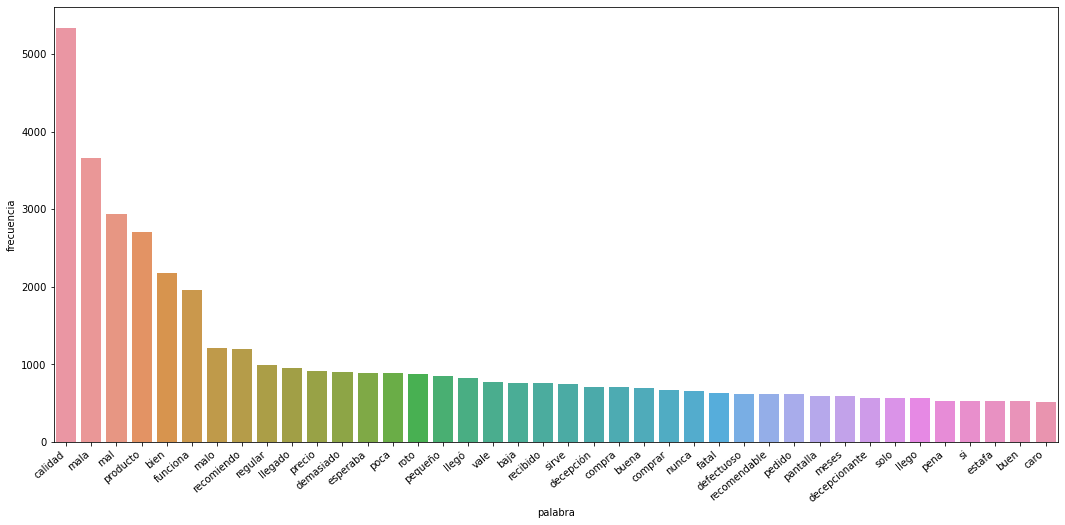

In [14]:
plt.figure(figsize = (18,8))
#Ordeno la primeras 40 palabras más presentes en reviews negativos (2 estrellas o menos)
plot = sns.barplot(x = frecuecia_palabras_neg.iloc[:40].palabra, y = frecuecia_palabras_neg.iloc[:40].frecuencia)
#Inclino las etiquetas
plot.set_xticklabels(plot.get_xticklabels(), rotation=40, ha="right")
plt.show()

Podemos observar que palabras como: <code>bien, funciona, recomiendo, buena o recomendable</code>, que se asociarían a reviews positivas, están muy presentes en reviews negativas esto puede <b>afectar</b> a como el modelo clasifica las mismas.

#### Veamos que pasa con las reviews positivas

In [15]:
dataset_posit

,review_id,product_id,stars,review_body,review_title,product_category
80000,es_0397380,product_es_0419842,3,"cabe bien un móvil de 5,5 y cumple su función ...","buena funda para movil 5,5",wireless
80001,es_0677179,product_es_0783495,3,El aparato tiene un tamaño perfecto. Y la embo...,"Aparato perfecto para verduras (no cebollas, n...",kitchen
80002,es_0977233,product_es_0602345,3,"La luces llegaron en tiempo y bien, las ocho f...",Poco duraderas,home
80003,es_0784422,product_es_0102982,3,"No sé puede apagar, está todo el rato consumie...",Lo peor es el apagado,home
80004,es_0399063,product_es_0312668,3,Vino sin la goma ajustable en la tapa y si pon...,Le faltó la goma a la tapa para que ajuste bien.,home
...,...,...,...,...,...,...
199995,es_0715276,product_es_0317036,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,electronics
199996,es_0085190,product_es_0622919,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,electronics
199997,es_0484496,product_es_0358101,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,apparel
199998,es_0930141,product_es_0788855,5,Perfecto para el cumple de mi hijo,Recomendado,toy


Podemos ver que el dataset de reviews positivas es 1/3 más grande

In [16]:
token_reviews_positivas=[]
#Tokenizamos y filtramos por stop words
for i in range(dataset_posit.shape[0]):
    review = dataset_posit.iloc[i].review_title.lower()
    review = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(review)
    review = [word for word in review if word not in stopwords] #filtro

    token_reviews_positivas.append(review)

In [17]:
frecuecia_palabras_posit = list(itertools.chain(*token_reviews_positivas))

frecuecia_palabras_posit = nltk.FreqDist(frecuecia_palabras_posit)

frecuecia_palabras_posit = pd.DataFrame(list(frecuecia_palabras_posit.items()), columns = ["palabra","frecuencia"])
frecuecia_palabras_posit.sort_values('frecuencia',ascending=False, inplace = True)

frecuecia_palabras_posit.head(10)

,palabra,frecuencia
22,calidad,10266
16,bien,9712
0,buena,9310
23,precio,7685
75,buen,7058
42,producto,4680
5,perfecto,4155
197,bueno,2816
160,compra,2678
187,cumple,2532


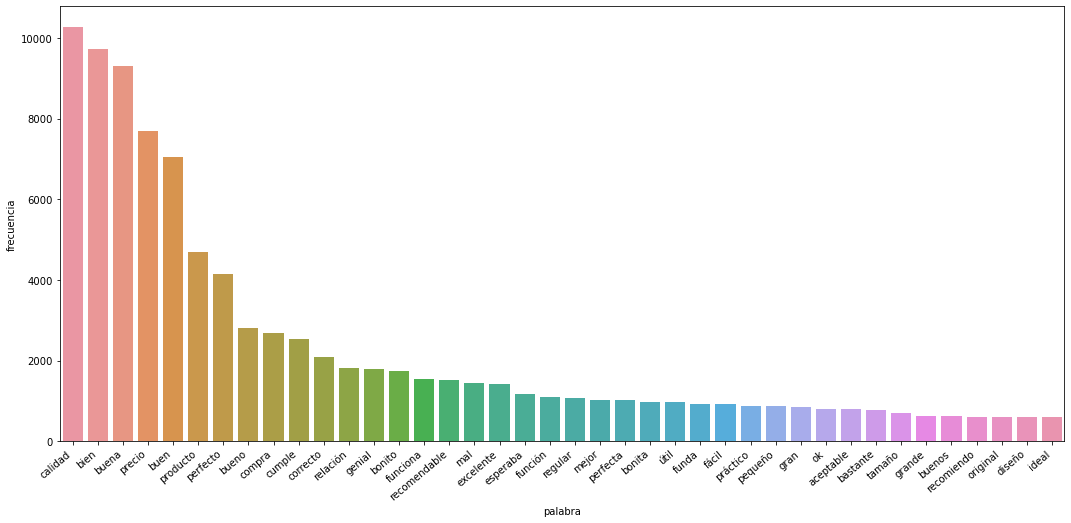

In [18]:
plt.figure(figsize = (18,8))
#Ordeno la primeras 40 palabras más presentes en reviews positivas (3 estrellas o mas)
plot = sns.barplot(x = frecuecia_palabras_posit.iloc[:40].palabra, y = frecuecia_palabras_posit.iloc[:40].frecuencia)
#Inclino las etiquetas
plot.set_xticklabels(plot.get_xticklabels(), rotation=40, ha="right")
plt.show()

A diferencia de las review negativas, las palabras utilizadas en las review positivas si son representativas de las mismas.

## Stemming y lemmatización


In [19]:
dataset_stemming=pd.concat([dataset.review_title,dataset.stars],axis=1)
dataset_stemming

,review_title,stars
0,television Nevir,1
1,Dinero tirado a la basura con esta compra,1
2,solo llega una unidad cuando te obligan a comp...,1
3,PRODUCTO NO RECIBIDO.,1
4,Devuelto,1
...,...,...
199995,Tal y como se describe,5
199996,Funciona perfectamente,5
199997,Buena calidad.,5
199998,Recomendado,5


In [20]:
# Libreria para reemplzar caracteres
import re
from nltk import SnowballStemmer

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()
snowball_stemmer = SnowballStemmer('spanish')


# Traemos nuevamente las stopwords
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords.remove('muy')
stopwords.remove('nada')
stopwords.remove('poco')
stopwords.remove('no')

In [21]:
#Funcion que remueve acentos de palabras
def remover_acentos(palabra):
    #Reglas o letras a cambiar
    reglas = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
        ("ñ", "n"),
    )
    for a, b in reglas:
        palabra = palabra.replace(a, b).replace(a.upper(), b.upper())
    return palabra

#### Normalizamos y lemmatizamos el dataset que preparamos con los 3 algoritmos que seleccionamos para compararlos y elegir uno

In [22]:

#Aca guardamos los lemmatizers que queremos probar
lista_de_lemmatizers = [wordnet_lemmatizer.lemmatize, porter_stemmer.stem, snowball_stemmer.stem]
resultados_lemmatizers= []#Array donde vamos a guardar los resultados de la lemmatización

#Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
for lemmatizer_seleccionado in lista_de_lemmatizers:
    #Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
    review_list=[]
    for review in dataset_stemming.review_title:
        # Vamos a reemplzar los caracteres que no sean letras por espacios
        review=remover_acentos(review)
        review=re.sub("[^a-zA-Z]"," ",str(review))
        # Pasamos todo a minúsculas
        review=review.lower()
        # Tokenizamos para separar las palabras del titular
        review=nltk.word_tokenize(review)
        # Eliminamos las palabras de menos de 3 letras
        review = [palabra for palabra in review if len(palabra)>=2]
        # Sacamos las Stopwords
        review = [palabra for palabra in review if not palabra in stopwords]

        ## Hasta acá Normalizamos, ahora a stemmizar

        # Aplicamos la funcion para buscar la raiz de las palabras
        review=[lemmatizer_seleccionado(palabra) for palabra in review]
        # Por ultimo volvemos a unir el titular
        review=" ".join(review)

        # Agregamos a la lista la review
        review_list.append(review)
        
    resultados_lemmatizers.append(review_list)

In [23]:
#comparamos los resultados de los 3 lemmatizers para saber cual utilizar
table = pd.DataFrame({'wordnet_lemmatizer': resultados_lemmatizers[0],
                     'porter_stemmer': resultados_lemmatizers[1],
                     'snowball_stemmer': resultados_lemmatizers[2]})
table.head(20)

,wordnet_lemmatizer,porter_stemmer,snowball_stemmer
0,television nevir,televis nevir,television nev
1,dinero tirado basura compra,dinero tirado basura compra,diner tir basur compr
2,solo llega unidad obligan comprar do,solo llega unidad obligan comprar do,sol lleg unid oblig compr dos
3,producto no recibido,producto no recibido,product no recib
4,devuelto,devuelto,devuelt
5,jamas llego,jama llego,jam lleg
6,horroroso,horroroso,horror
7,poco funcional,poco funcion,poc funcional
8,no llego,no llego,no lleg
9,mala calidad defectuoso,mala calidad defectuoso,mal calid defectu


Viendo la comparación de cada lemmatizer, <code>wordnet_lemmatizer</code> pareciera tener un mejor desempeño reconociendo las palabras.
Al ser en español las reviews el lemmatizer no puede utilizar un sistema basado en reglas sino sino que funciona por un lookup de corpus, haciendo que el resultado sea peor.

In [24]:
#Agregamos al dataset 
dataset_stemming["wordnet_lemmatizer"] = resultados_lemmatizers[0]
dataset_stemming

,review_title,stars,wordnet_lemmatizer
0,television Nevir,1,television nevir
1,Dinero tirado a la basura con esta compra,1,dinero tirado basura compra
2,solo llega una unidad cuando te obligan a comp...,1,solo llega unidad obligan comprar do
3,PRODUCTO NO RECIBIDO.,1,producto no recibido
4,Devuelto,1,devuelto
...,...,...,...
199995,Tal y como se describe,5,tal describe
199996,Funciona perfectamente,5,funciona perfectamente
199997,Buena calidad.,5,buena calidad
199998,Recomendado,5,recomendado


In [25]:
dataset_lemm = dataset_stemming.drop("review_title",axis=1)
dataset_lemm

,stars,wordnet_lemmatizer
0,1,television nevir
1,1,dinero tirado basura compra
2,1,solo llega unidad obligan comprar do
3,1,producto no recibido
4,1,devuelto
...,...,...
199995,5,tal describe
199996,5,funciona perfectamente
199997,5,buena calidad
199998,5,recomendado


### Vectorizar

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000
rango_ngrams=(1, 4)
# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features,ngram_range=rango_ngrams) # stop_words="english" , ngram_range=(1, 2)

In [27]:
vector_reviews = cou_vec.fit_transform(list(dataset_lemm['wordnet_lemmatizer'].values))

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las primeras 50 de las palabras mas usadas, estan ordenadas alfabeticamente
print("50 palabras mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['abierto', 'acabado', 'acabados', 'accesorios', 'aceite', 'aceptable', 'acierto', 'aconsejable', 'aconsejo', 'acorde', 'adapta', 'adaptador', 'adecuado', 'adhesivo', 'agradable', 'agua', 'aguanta', 'ahora', 'aire', 'ajusta', 'ajusta bien', 'ajuste', 'algun', 'alta', 'altavoz', 'alto', 'amazon', 'ana', 'ano', 'antonio', 'anunciado', 'anuncio', 'aparato', 'apenas', 'apto', 'articulo', 'asi', 'aspecto', 'atencion', 'atencion cliente', 'audio', 'aun', 'aun no', 'aunque', 'auriculare', 'ayuda', 'baja', 'baja calidad', 'bajo', 'barata']


## Modelo

In [28]:
#Definimos X e Y
x = vector_reviews.toarray() # Features predictoreos 
y = dataset_lemm['stars'].values # Valores a predecir

xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42)

In [29]:
#Funcion para poder graficar la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    stars=["1","2","3","4","5"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(stars)
    ax.set_yticklabels(stars)
    plt.show()

    return

#### Modelo Gaussiano
Se espera que tenga un desempeño malo dado que el este modelo está enfocado en predicciones binarias y no como la que deseamos de 5 estrellas

In [30]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)
print("acc : ", nb.score(xtest,ytest))

acc :  0.356275


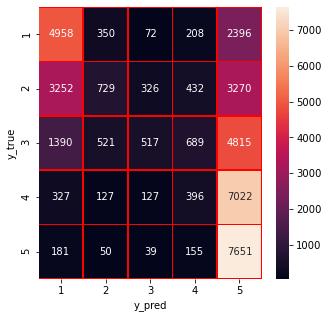

In [31]:
y_pred=nb.predict(xtest)
confusion(ytest,y_pred)

Podemos ver que clasifica casi todo en 1 o 5 estrellas, haciendoq que sea muy impreciso 

#### Random forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

rf = RandomForestClassifier(n_estimators = 25, random_state=42)
rf.fit(xtrain,ytrain)

RandomForestClassifier(n_estimators=25, random_state=42)

In [39]:
print("acc: ",rf.score(xtest,ytest))

acc:  0.43965


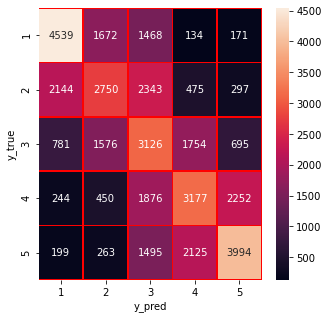

In [42]:
y_pred=rf.predict(xtest)
confusion(ytest,y_pred)


Podemos ver que clasifica mejor que el modelo anterior aunque sigue siendo impreciso.


Además con el modelo <code>RandomForest</code> podemos ver la importancia de cada feature generado por el <code>Vectorizer</code>

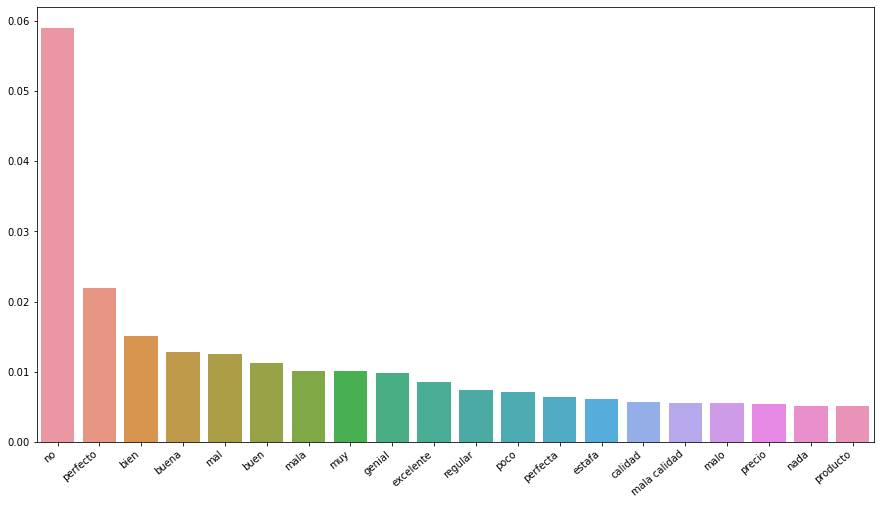

In [43]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words = cou_vec.get_feature_names()
columns = all_words

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (15,8))
plot=sns.barplot(selected_columns, selected_importances)
plot.set_xticklabels(plot.get_xticklabels(), rotation=40, ha="right")
plt.show()

## SVM

In [44]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C = 1)
svc.fit(xtrain,ytrain)
svc.score(xtest,ytest)

D:\Anaconda\envs\data_science\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.44485

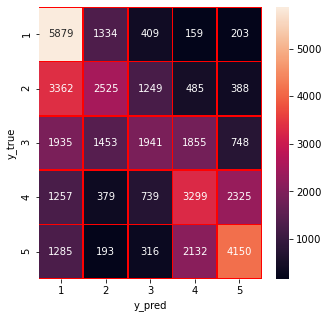

In [45]:
y_pred=svc.predict(xtest)
confusion(ytest,y_pred)

Podemos ver que la linea donde se presentaba el mayor error, el 3 predicho,se desplazó al 1 predicho, haciendo que sea incluso peor el desempeño

## Spacy

Como los resultados podrian ser mejores, vamos a porbar utilizar Spacy y sus funciones para lemmatizar, vectorizar y modelar.

Importamos de nuevo el dataset para poder trabajar en limpio y ver como se comporta si lo normalizamos y transformamos con Spacy

In [46]:
dataset = pd.read_json('dataset_amazon/dataset_es_train.json', lines = True)
dataset

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes
...,...,...,...,...,...,...,...,...
199995,es_0715276,product_es_0317036,reviewer_es_0643604,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,es,electronics
199996,es_0085190,product_es_0622919,reviewer_es_0466173,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,es,electronics
199997,es_0484496,product_es_0358101,reviewer_es_0330744,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,es,apparel
199998,es_0930141,product_es_0788855,reviewer_es_0694290,5,Perfecto para el cumple de mi hijo,Recomendado,es,toy


In [47]:
dataset.drop(['language','reviewer_id','product_id','review_id','product_category'],axis = 1,inplace=True)
dataset

,stars,review_body,review_title
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.
4,1,Llega tarde y co la talla equivocada,Devuelto
...,...,...,...
199995,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe
199996,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente
199997,5,Buena calidad. Satisfecha con la compra.,Buena calidad.
199998,5,Perfecto para el cumple de mi hijo,Recomendado


In [48]:
from spacy import displacy
nlp = spacy.load("es_core_news_sm") # Cargamos la versión en español

In [49]:
text = "Esta es una oracion de prueba"
doc = nlp(text)
doc

Esta es una oracion de prueba

In [50]:
from spacy.lang.es.examples import sentences 
doc = nlp("Muy bueno el producto, llego un poco tarde pero funciona")
print("Oracion original: ", doc.text)
for token in doc:
    print(token.text,token.lemma_ )

Oracion original:  Muy bueno el producto, llego un poco tarde pero funciona
Muy Muy
bueno bueno
el el
producto producto
, ,
llego llegar
un uno
poco poco
tarde tardar
pero pero
funciona funcionar


Se puede ver que el lemmatiza bien aunque por ejemplo un lo tomo como una unidad.

Spacy tiene funciones que sirven para graficar como se comporta cada token en la oración

In [51]:
displacy.render(doc, style = 'dep')

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [53]:
dataset

,stars,review_body,review_title
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.
4,1,Llega tarde y co la talla equivocada,Devuelto
...,...,...,...
199995,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe
199996,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente
199997,5,Buena calidad. Satisfecha con la compra.,Buena calidad.
199998,5,Perfecto para el cumple de mi hijo,Recomendado


In [54]:
# Libreria para reemplzar caracteres
import re
from nltk import SnowballStemmer

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()
snowball_stemmer = SnowballStemmer('spanish')


# Traemos nuevamente las stopwords
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords.remove('muy')
stopwords.remove('nada')
stopwords.remove('poco')
stopwords.remove('no')

In [211]:
#Funcion que tokeniza y normaliza las oraciones

def token_cleaner(oracion):
    doc = nlp(oracion)
    temp=[]
    for token in doc:
        # Vamos a reemplzar los caracteres que no sean letras por espacios
        token=remover_acentos(token.lemma_)
        token=re.sub("[^a-zA-Z]"," ",str(token))
        # Pasamos todo a minúsculas
        token=token.lower()
        # Tokenizamos para separar las palabras del titular
        token=nltk.word_tokenize(token)
        # Eliminamos las palabras de menos de 3 letras
        token = [palabra for palabra in token if len(palabra)>=2]
        # Sacamos las Stopwords
        token = [palabra for palabra in token if not palabra in stopwords ]

        ## Hasta acá Normalizamos, ahora a stemmizar
        
        # Por ultimo volvemos a unir el titular
        token="".join(token)

        # Agregamos a la lista la review
        temp.append(token)
        
    temp = list(filter(None, temp))
    
    return(temp)


In [197]:
punct = string.punctuation

def text_data_cleaning(sentence):
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        temp = token.lower_
        tokens.append(temp)
    
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords and token not in punct:
            cleaned_tokens.append(token)
    return cleaned_tokens

In [212]:
#probamos que funcione la función
token_cleaner("Muy bueno el producto, llegó un poco tarde pero funciona")

['muy', 'bueno', 'producto', 'llegar', 'poco', 'tardar', 'funcionar']

In [103]:
#Como calsificador vamos usar un SVC y para tokenizar TFIDF, que debería tener un mejor desempeño
from sklearn.svm import LinearSVC
tfidf = TfidfVectorizer(tokenizer = token_cleaner)
classifier = LinearSVC()

Dividimos, entrenamos y predecimos como siempre

In [213]:
X = dataset['review_title']
y = dataset['stars']

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [215]:
clf = Pipeline([('tfidf', tfidf), ('clf', classifier)])

In [216]:
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function token_cleaner at 0x00000254D8E72EE0>)),
                ('clf', LinearSVC())])

In [217]:
y_pred = clf.predict(X_test)

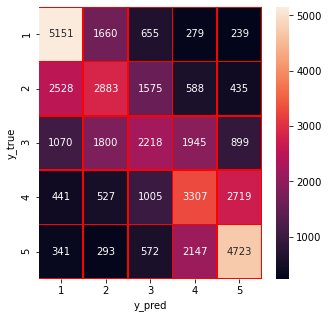

In [218]:
confusion(y_test,y_pred)

In [219]:
clf.score(X_test,y_test)

0.45705

Probamos con unos titulos basicos a ver como clasifica a mano

In [66]:
titulosdeprueba = [["muy malo",0],["malo",0],["bueno",0], ["medio malo",0],["excelente",0], ["si me sirvio para lo que es",0], ["Buen precio calidad",0]]

for titulo in titulosdeprueba:
    titulo[1]=clf.predict([titulo[0]])[0]

In [67]:
tabla_titulosdeprueba = pd.DataFrame(titulosdeprueba, columns = ["Review","Puntaje predicho"])

tabla_titulosdeprueba

,Review,Puntaje predicho
0,muy malo,1
1,malo,1
2,bueno,4
3,medio malo,2
4,excelente,5
5,si me sirvio para lo que es,2
6,Buen precio calidad,4


Como se puede ver en el diagrama de confusión y lo visto en estos titulos de prueba clasifica de forma aceptable

## Conclusiones

El mejor modelo es el <code>SCV</code> utilizando <code>TfidfVectorizer</code>. La matriz de confusión muestra una diagonal marcada que se difumina y tiende a acertar la clasificación o a "errar" por +- 1 estrella. Hablo de "error" entre comillas dado que el lenguaje es subjetivo y más cuando se trata de opiniones, haciendo que predecir con exactitud la calificación predicha sea más una aproximación y no un puntaje exacto por lo que utilizar un <code>Score</code> para medir la exactitud del modelo no es tan útil como ver la matriz de confusión.
<br>
Tambien hay algunos problemas para lematizar o sacar la raiz de las palabras en español con las librerias usadas. Igualmente el modelo fue capaz de clasificar bien y distinguir no solo las palabras clave sino que tambien potenciadores de esta o palabras negatorias haciendo que un "El producto no es muy bueno" sea clasificado correctamente.
<br>
Si se quisiera que el Acurracy el modelo sea mayor, se debería reducir las opciones a predecir de 1/5 a malo/regular/bueno o no recomendable/recomendable

## Más adelante

Para la proxima entrega sera muy interesante ver que sucede si se utiliza <code>Word2Vec</code>.
<br>
Se podría usar para saber la cantidad de reviews negativas relacionadas con las entregas por ejemplo.